In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import math
import os
import sys
from pathlib import Path
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import redis
from jaxfi import jaxm
from line_profiler import LineProfiler

root_path = Path("").absolute().parent
if str(root_path) not in sys.path:
    sys.path.insert(0, str(root_path))
from pmpc import solve as pmpc_solve

from mpcjax import solve, SolverSettings
from mpcjax.jax_solver import _build_problems
from mpcjax.problem_struct import Problem
from tests.dynamics import f_fx_fu_fn

# jaxm.set_default_dtype(np.float64)

In [15]:
N, xdim, udim = 20, 4, 2

Q = np.tile(np.eye(xdim), (N, 1, 1))
R = np.tile(1e-2 * np.eye(udim), (N, 1, 1))
x0 = np.tile(np.ones(xdim), (1,))
X_ref, U_ref = np.zeros((N, xdim)), np.zeros((N, udim))
X_prev, U_prev = np.zeros((N, xdim)), np.zeros((N, udim))
u_lim = 1.0
u_l, u_u = -u_lim * np.ones((N, udim)), u_lim * np.ones((N, udim))

problem = dict(
    f_fx_fu_fn=f_fx_fu_fn,
    Q=Q,
    R=R,
    x0=x0,
    X_ref=X_ref,
    U_ref=U_ref,
    X_prev=X_prev,
    U_prev=U_prev,
    u_l=u_l,
    u_u=u_u,
    solver_settings=SolverSettings(maxls=1000, max_it=10),
    reg_x=1e0,
    reg_u=1e-1,
    max_it=50,
    res_tol=-1e-12,
    verbose=True,
    slew_rate=1e-5,
    P=1.0 * jaxm.ones((N, 1)),
    #dtype=np.float64,
    smooth_alpha=1e6,
)
problem = jaxm.to(problem, device="cuda", dtype=jaxm.float32)
#problem["U_prev"] = float("nan") * problem["U_prev"]

In [16]:
problem = jaxm.to(problem, dtype=jaxm.float32)
problem["U_prev"]
print(problem["U_prev"].dtype)

float32


# solve

In [17]:
import time
t = time.time()
X1, U1, data = solve(**problem, direct_solve=False)
t = time.time() - t
print(f"Direct solve took {t:.4e} s")
print(f"dtype = {X1.dtype}, device = {X1.device()}")

+------+------------+------------+------------+----------+----------+----------+
|  it  |   elaps    |    obj     |   resid    |  reg_x   |  reg_u   |  alpha   |
+------+------------+------------+------------+----------+----------+----------+
| 0001 |  0.000e+00 |  5.313e+01 |  1.093e+01 |  1.0e+00 |  1.0e-01 |  1.0e+06 |
| 0002 |  0.000e+00 |  1.136e+01 |  5.443e+00 |  1.0e+00 |  1.0e-01 |  1.0e+06 |
| 0003 |  0.000e+00 |  3.076e+00 |  2.756e+00 |  1.0e+00 |  1.0e-01 |  1.0e+06 |
| 0004 |  0.000e+00 |  9.805e-01 |  1.213e+00 |  1.0e+00 |  1.0e-01 |  1.0e+06 |
| 0005 |  0.000e+00 |  7.110e-01 |  4.749e-02 |  1.0e+00 |  1.0e-01 |  1.0e+06 |
| 0006 |  0.000e+00 |  7.107e-01 |  2.421e-07 |  1.0e+00 |  1.0e-01 |  1.0e+06 |
| 0007 |  0.000e+00 |  7.107e-01 |  3.589e-07 |  1.0e+00 |  1.0e-01 |  1.0e+06 |
| 0008 |  0.000e+00 |  7.107e-01 |  0.000e+00 |  1.0e+00 |  1.0e-01 |  1.0e+06 |
| 0009 |  0.000e+00 |  7.107e-01 |  0.000e+00 |  1.0e+00 |  1.0e-01 |  1.0e+06 |
| 0010 |  0.000e+00 |  7.107

/tmp/ipykernel_2327152/3093979268.py:6: DeprecationWarning: arr.device() is deprecated. Use arr.devices() instead.
  print(f"dtype = {X1.dtype}, device = {X1.device()}")


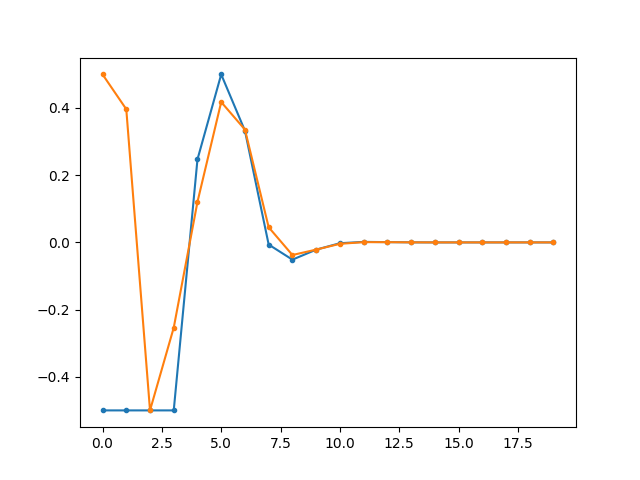

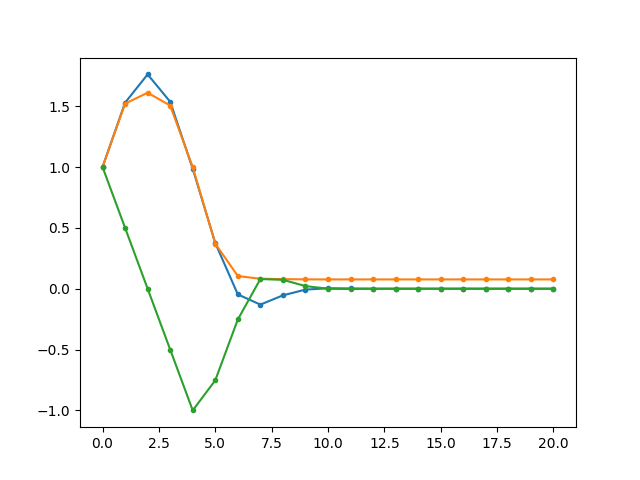

In [36]:
plt.figure()
plt.plot(X1[:, 0], marker=".")
plt.plot(X1[:, 1], marker=".")
plt.plot(X1[:, 2], marker=".")

plt.figure()
plt.plot(U1[:, 0], marker=".")
plt.plot(U1[:, 1], marker=".")
plt.show()


In [ ]:
X2, U2, _ = solve(**problem, direct_solve=False)
X3, U3, _ = pmpc_solve(
    **dict(
        problem,
        solver_settings=dict(problem["solver_settings"], solver="ecos"),
    )
)
print(f"dtype = {X1.dtype}, device = {X1.device()}")

In [ ]:
print(f"{jaxm.max(jaxm.abs(U1 - U2)):.4e}")
print(f"{jaxm.max(jaxm.abs(U1 - U3)):.4e}")
print(f"{jaxm.max(jaxm.abs(X1 - X2)):.4e}")
print(f"{jaxm.max(jaxm.abs(X1 - X3)):.4e}")
print()
print(f"{jaxm.norm(U1 - U2):.4e}")
print(f"{jaxm.norm(U1 - U3):.4e}")
print(f"{jaxm.norm(X1 - X2):.4e}")
print(f"{jaxm.norm(X1 - X3):.4e}")

# Plot the results for a qualitative check

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
for i in range(X.shape[-1]):
    ax[0].plot(X[:, i], label=f"$x_{i}$")
ax[0].legend()
for i in range(U.shape[-1]):
    ax[1].plot(U[:, i], label=f"$u_{i}$")
ax[1].legend()

# Check optimality conditions

In [ ]:
def solve(H, g, dtype=jaxm.float64):
    return jaxm.linalg.solve(*jaxm.to((H, g), dtype=dtype))

def solve_precond(H, g, L, R, dtype=jaxm.float64):
    H, g, L, r = jaxm.to((H, g, L, R), dtype=dtype)
    H = jaxm.diag(1.0 / L) @ H @ jaxm.diag(1.0 / R)
    g = g / L
    return jaxm.linalg.solve(H, g) / R

def cond(H):
    return jaxm.linalg.cond(jaxm.to(H, device="cpu", dtype=jaxm.float64))

In [ ]:
H = jaxm.randn((100, 100))
g = jaxm.randn((100,))
Q = jaxm.linalg.qr(H)[0]
H = Q @ jaxm.diag(jaxm.logspace(-9, 0, Q.shape[-1])) @ Q.T

ys = solve(H, g)
L, R = jaxm.linalg.norm(H, axis=-1), jaxm.linalg.norm(H, axis=-2)
L2, R2 = jaxm.linalg.norm(H, axis=-2), jaxm.linalg.norm(H, axis=-1)

print(f"{jaxm.norm(ys - solve(H, g, jaxm.float32)) / jaxm.norm(ys):.4e}")
print(f"{jaxm.norm(ys - solve_precond(H, g, L, R, jaxm.float32)) / jaxm.norm(ys):.4e}")
print(f"{jaxm.norm(ys - solve_precond(H, g, L2, R2, jaxm.float32)) / jaxm.norm(ys):.4e}")
print(f"{jaxm.norm(ys - solve_precond(H, g, L, jaxm.ones(R.shape), jaxm.float32)) / jaxm.norm(ys):.4e}")
print(f"{jaxm.norm(ys - solve_precond(H, g, L2, jaxm.ones(R.shape), jaxm.float32)) / jaxm.norm(ys):.4e}")
print(f"{jaxm.norm(ys - solve_precond(H, g, jaxm.ones(R.shape), R, jaxm.float32)) / jaxm.norm(ys):.4e}")
print(f"{jaxm.norm(ys - solve_precond(H, g, jaxm.ones(R.shape), R2, jaxm.float32)) / jaxm.norm(ys):.4e}")

In [ ]:
print(f"{cond(jaxm.diag(1.0 / L) @ H @ jaxm.diag(1.0 / R)):.4e}")
print(f"{cond(jaxm.diag(1.0 / L2) @ H @ jaxm.diag(1.0 / R2)):.4e}")
print(f"{cond(jaxm.diag(1.0 / L) @ H):.4e}")
print(f"{cond(jaxm.diag(1.0 / L2) @ H):.4e}")
print(f"{cond(H @ jaxm.diag(1.0 / R)):.4e}")
print(f"{cond(H @ jaxm.diag(1.0 / R2)):.4e}")
print(f"{cond(H):.4e}")